# Setup

In [1]:
!apt install libmpc-dev
!pip install gmpy2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgmp-dev libgmpxx4ldbl libmpfr-dev
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-doc
The following NEW packages will be installed:
  libgmp-dev libgmpxx4ldbl libmpc-dev libmpfr-dev
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 625 kB of archives.
After this operation, 3,178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgmpxx4ldbl amd64 2:6.1.2+dfsg-2 [8,964 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgmp-dev amd64 2:6.1.2+dfsg-2 [316 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmpfr-dev amd64 4.0.1-1 [249 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmpc-dev 

In [2]:
!unzip '/content/1.zip' -d '/content/'


Archive:  /content/1.zip
  inflating: /content/.ipynb_checkpoints/autoencoders_test-checkpoint.ipynb  
  inflating: /content/.ipynb_checkpoints/autoencoders-checkpoint.ipynb  
  inflating: /content/images/crypto1.png  
  inflating: /content/images/crypto1-encall.png  
  inflating: /content/images/crypto1-eve0.png  
  inflating: /content/images/crypto1-eve1.png  
  inflating: /content/images/crypto2-2k.png  
  inflating: /content/images/crypto2-3k.png  
  inflating: /content/images/crypto2-5k.png  
  inflating: /content/images/crypto2-all.png  
  inflating: /content/images/k_auto_conv1_kerpca2d-all.png  
  inflating: /content/images/k_auto_conv1_kerpca3d-all.png  
  inflating: /content/images/k_auto_conv1_pca2d-all.png  
  inflating: /content/images/k_auto_conv1_pca3d-all.png  
  inflating: /content/images/k_auto_conv1_rec.gif  
  inflating: /content/images/k_auto_conv1-gen.png  
  inflating: /content/images/k_auto0_enc-hist.png  
  inflating: /content/images/k_auto0_gen.png  
  inflati

In [3]:
%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import load_model

In [4]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

# Symmetric (secret-key) encryption

## Model `crypto1` (Google)

This model was build according to the specifications from Google's paper *Learning to protect communications with adversarial neural cryptography*.

In [5]:
model_name = 'crypto1'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'

### Network arch

In [6]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('sigmoid')(aconv4)

aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('sigmoid')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('sigmoid')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [7]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [8]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [9]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train / save / restore

In [10]:
abelosses = []
boblosses = []
evelosses = []

In [11]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 7.845 | eve: 7.719 | bob: 7.833
Epoch   1:  99% | abe: 6.191 | eve: 6.067 | bob: 6.100
Epoch   2:  99% | abe: 4.242 | eve: 4.268 | bob: 3.986
Epoch   3:  99% | abe: 2.779 | eve: 2.701 | bob: 2.304
Epoch   4:  99% | abe: 1.911 | eve: 1.813 | bob: 1.282
Epoch   5:  99% | abe: 1.382 | eve: 1.314 | bob: 0.656
Epoch   6:  99% | abe: 1.038 | eve: 1.320 | bob: 0.318
Epoch   7:  99% | abe: 0.782 | eve: 1.890 | bob: 0.181
Epoch   8:  99% | abe: 0.602 | eve: 2.571 | bob: 0.129
Epoch   9:  99% | abe: 0.500 | eve: 3.040 | bob: 0.102
Epoch  10:  99% | abe: 0.426 | eve: 3.413 | bob: 0.085
Epoch  11:  99% | abe: 0.388 | eve: 3.678 | bob: 0.087
Epoch  12:  99% | abe: 0.344 | eve: 3.904 | bob: 0.072
Epoch  13:  99% | abe: 0.323 | eve: 4.082 | bob: 0.075
Epoch  14:  99% | abe: 0.303 | eve: 4.250 | bob: 0.073
Epoch  15:  99% | abe: 0.290 | eve: 4.368 | bob: 0.077
Epoch  16:  99% | abe: 0.270 | eve: 4.482 | bob: 0.070
Epoch  17:  9

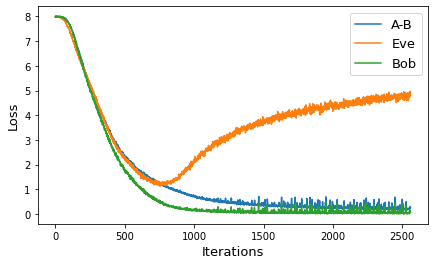

In [12]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [13]:
if False: #Don't overwrite by accident
    alice.save(alice_file + '.h5', overwrite=True)
    bob.save(bob_file + '.h5', overwrite=True)
    eve.save(eve_file + '.h5', overwrite=True)

In [14]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [15]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  89.06 %
Eve % correct:  0.2 %


### Freeze Alice-Bob

In [16]:
if False:
    alice = load_model(alice_file + '.h5')
    bob = load_model(bob_file + '.h5')
    eve = load_model(eve_file + '.h5')

aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = Adam()#RMSprop(lr=0.001) #default 0.001

abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

abelosses = []
boblosses = []
evelosses = []

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        # Train Eve model only
        #
        alice.trainable = False
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eveloss = evemodel.train_on_batch([m_batch, k_batch], None)
        evelosses0.append(eveloss)
        evelosses.append(eveloss)
        eveavg = np.mean(evelosses0)
        
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        bobloss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(bobloss)
        boblosses.append(bobloss)
        bobavg = np.mean(boblosses0)
        
        # Evaluate the ABE loss
        abeloss = bobloss + ((m_bits/2 - eveloss)**2) / ( (m_bits//2)**2 )
        abelosses0.append(abeloss)
        abelosses.append(abeloss)
        abeavg = np.mean(abelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 0.272 | eve: 4.857 | bob: 0.118
Epoch   1:  99% | abe: 0.274 | eve: 4.843 | bob: 0.118
Epoch   2:  99% | abe: 0.272 | eve: 4.851 | bob: 0.117
Epoch   3:  99% | abe: 0.272 | eve: 4.860 | bob: 0.118
Epoch   4:  99% | abe: 0.273 | eve: 4.856 | bob: 0.119
Epoch   5:  99% | abe: 0.273 | eve: 4.835 | bob: 0.116
Epoch   6:  99% | abe: 0.274 | eve: 4.844 | bob: 0.118
Epoch   7:  99% | abe: 0.277 | eve: 4.824 | bob: 0.119
Epoch   8:  99% | abe: 0.273 | eve: 4.850 | bob: 0.118
Epoch   9:  99% | abe: 0.273 | eve: 4.848 | bob: 0.118
Epoch  10:  99% | abe: 0.275 | eve: 4.829 | bob: 0.117
Epoch  11:  99% | abe: 0.277 | eve: 4.832 | bob: 0.120
Epoch  12:  99% | abe: 0.275 | eve: 4.848 | bob: 0.120
Epoch  13:  99% | abe: 0.271 | eve: 4.854 | bob: 0.116
Epoch  14:  99% | abe: 0.275 | eve: 4.845 | bob: 0.119
Epoch  15:  99% | abe: 0.273 | eve: 4.844 | bob: 0.117
Epoch  16:  99% | abe: 0.275 | eve: 4.851 | bob: 0.120
Epoch  17:  9

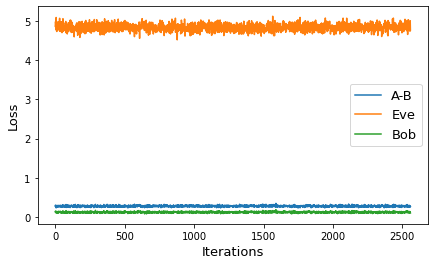

In [18]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [19]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  88.7 %
Eve % correct:  0.22 %


### Encoding distribution

In [20]:
#X_encoded = encoder.predict(X_train, verbose=True)
#print(X_encoded.shape)

Let's plot a few of the encoded vectors' coodinates:

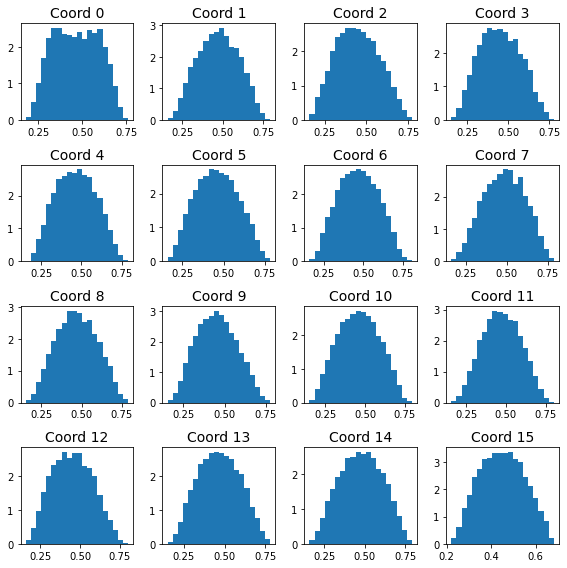

In [21]:
n_examples = 10000
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 4],
    [ 5, 6, 7, 14]
])

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
m_enc = alice.predict([m_batch, k_batch])

if showAll:
    n_cols = 4
    n_rows = m_enc.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(8, int(8.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i), fontsize=14)
            plt.hist(m_enc[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]), fontsize=12)
            plt.hist(m_enc[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
#plt.savefig("images/" + model_name + "-encall.png", transparent=True) #dpi=100
plt.show()

In [22]:
# Let's examine various correlations, if any
data_arr = np.c_[m_batch, k_batch, m_enc]

columns = [
    'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 
    'k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 
    'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 
]

data = pd.DataFrame(data=data_arr, index=range(10000), columns=columns)
data.head()

,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.622822,0.551930,0.464660,0.497391,0.628738,0.390513,0.524393,0.772090,0.495701,0.478259,0.285157,0.450633,0.696988,0.562439,0.542532,0.462469
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.561920,0.596993,0.270274,0.435648,0.712788,0.639466,0.283177,0.305622,0.415267,0.481317,0.448446,0.430723,0.384107,0.565892,0.625926,0.306543
2,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.455276,0.501030,0.170851,0.237002,0.393178,0.467334,0.627514,0.699010,0.506557,0.550756,0.532146,0.503845,0.601732,0.544569,0.506679,0.391432
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.469618,0.628110,0.437071,0.523563,0.544178,0.430207,0.367221,0.537460,0.376086,0.344731,0.434787,0.783432,0.530220,0.570984,0.604458,0.394901
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.381497,0.666067,0.318310,0.369689,0.483722,0.352637,0.327396,0.391037,0.415266,0.212816,0.398896,0.562565,0.407037,0.333733,0.355647,0.257469


In [23]:
datac = data[['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15']]
datac.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,0.622822,0.551930,0.464660,0.497391,0.628738,0.390513,0.524393,0.772090,0.495701,0.478259,0.285157,0.450633,0.696988,0.562439,0.542532,0.462469
1,0.561920,0.596993,0.270274,0.435648,0.712788,0.639466,0.283177,0.305622,0.415267,0.481317,0.448446,0.430723,0.384107,0.565892,0.625926,0.306543
2,0.455276,0.501030,0.170851,0.237002,0.393178,0.467334,0.627514,0.699010,0.506557,0.550756,0.532146,0.503845,0.601732,0.544569,0.506679,0.391432
3,0.469618,0.628110,0.437071,0.523563,0.544178,0.430207,0.367221,0.537460,0.376086,0.344731,0.434787,0.783432,0.530220,0.570984,0.604458,0.394901
4,0.381497,0.666067,0.318310,0.369689,0.483722,0.352637,0.327396,0.391037,0.415266,0.212816,0.398896,0.562565,0.407037,0.333733,0.355647,0.257469


In [24]:
corr = data.corr()
corrc = datac.corr()

In [25]:
corrc['c2'].sort_values(ascending=False)

c2     1.000000
c1     0.178766
c11    0.127418
c3     0.102182
c14    0.083323
c0     0.075502
c4     0.026612
c9     0.023792
c5     0.020511
c12    0.017699
c15    0.006086
c6     0.000411
c8    -0.000688
c7    -0.022296
c13   -0.030016
c10   -0.055956
Name: c2, dtype: float64

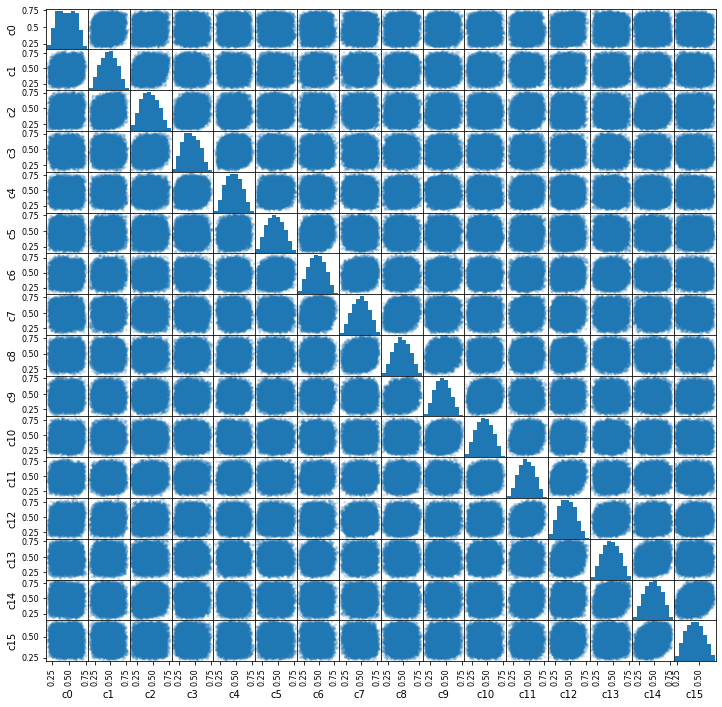

In [26]:
pd.plotting.scatter_matrix(datac, alpha=0.2, figsize=(12,12))
plt.show()

## Model `crypto2`

Add dense, and allow tanh for codings.

In [27]:
K.floatx()

'float32'

In [28]:
model_name = 'crypto2'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'

### Network arch

In [29]:
K.clear_session()
kersize = 4

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)

areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aflat = Flatten()(aconv4a)
aoutput = Dense(units=c_bits, activation='tanh')(aflat) #ciphertext

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

bflat = Flatten()(bconv4a)
boutput = Dense(units=m_bits, activation='sigmoid')(bflat) #decrypted message

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)
edense2 = Dense(units=(m_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((m_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eflat = Flatten()(econv4a)
eoutput = Dense(units=m_bits, activation='sigmoid')(eflat) #code break attempt

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [30]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [31]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [32]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = Adam()#RMSprop(lr=0.0015)
eveoptim = Adam()#RMSprop(lr=0.0015) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

### Train / save / restore

In [33]:
# Keep track of loss at every iteration for the final graph
abelosses = []
boblosses = []
evelosses = []

In [34]:
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 30 epochs with 256 batches of size 256
Epoch   0:  99% | abe: 2.539 | eve: 2.547 | bob: 2.364
Epoch   1:  99% | abe: 1.016 | eve: 1.824 | bob: 0.707
Epoch   2:  99% | abe: 0.458 | eve: 2.344 | bob: 0.279
Epoch   3:  99% | abe: 0.273 | eve: 2.703 | bob: 0.162
Epoch   4:  99% | abe: 0.156 | eve: 2.728 | bob: 0.052
Epoch   5:  99% | abe: 0.115 | eve: 2.898 | bob: 0.037
Epoch   6:  99% | abe: 0.079 | eve: 3.089 | bob: 0.025
Epoch   7:  99% | abe: 0.071 | eve: 3.111 | bob: 0.020
Epoch   8:  99% | abe: 0.069 | eve: 3.112 | bob: 0.017
Epoch   9:  99% | abe: 0.053 | eve: 3.236 | bob: 0.014
Epoch  10:  99% | abe: 0.036 | eve: 3.400 | bob: 0.012
Epoch  11:  99% | abe: 0.039 | eve: 3.361 | bob: 0.012
Epoch  12:  99% | abe: 0.048 | eve: 3.332 | bob: 0.019
Epoch  13:  99% | abe: 0.038 | eve: 3.296 | bob: 0.006
Epoch  14:  99% | abe: 0.024 | eve: 3.449 | bob: 0.005
Epoch  15:  99% | abe: 0.028 | eve: 3.417 | bob: 0.005
Epoch  16:  99% | abe: 0.029 | eve: 3.413 | bob: 0.006
Epoch  17:  9

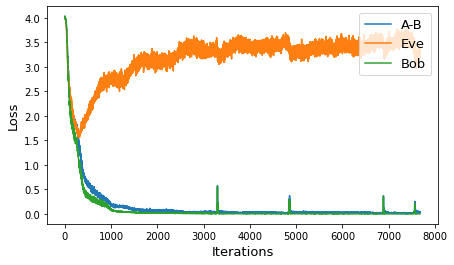

In [35]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

#plt.savefig("images/" + model_name + "-all.png", transparent=True) #dpi=100
plt.show()

In [36]:
alice.save(alice_file + '.h5', overwrite=True)
bob.save(bob_file + '.h5', overwrite=True)
eve.save(eve_file + '.h5', overwrite=True)

In [37]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [38]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
#m_enc = np.round(m_enc, 3)
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  99.95 %
Eve % correct:  1.56 %


# Asymmetric (public-key) encryption

## Model crypto3 (Google)

In [39]:
# Coming soon

# AI-based encryption (POC)

Let's take model `crypto2`, for which Bob was incredibly accurate while Eve failed to decrypt the messages.

We construct a full encryption, with 32-bit float ciphertexts (vector of dim 8), so each character will encode to 32 * 8 = 256 bits

**Encryption Algorithm:**
* Convert character string to binary
* Pad the binary char encoding string wtih 3 random bits to get a block of 8 bits per character
* Pass 8-bit blocks of the string through the encryption network Bob
* The output is 8-dim vectors of type `float32`, for a total of $8 \cdot 32 = 256$ bits per character
* Convert the output to a binary string by concatenating the binary representation of each component the 8-dim float vector. **This is the encoding**

One could convert this to a character string to see what the messasge might look like. Each character will be a block of 5 (remove 3 bits for padding).

The decryption algorithm is the reverse of the above.

In [40]:
alice = load_model('models/crypto/crypto2-alice.h5')
bob = load_model('models/crypto/crypto2-bob.h5')
eve = load_model('models/crypto/crypto2-eve.h5')

## Char map and str functions

In [41]:
block_size_unpadded = 5
block_padding = 3
block_size = block_size_unpadded + block_padding

chrlist = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '!', '?',
    ':', ' '
]
binlist = [
    '00000', '00001', '00010', '00011', '00100', 
    '00101', '00110', '00111', '01000', '01001',
    '01010', '01011', '01100', '01101', '01110', 
    '01111', '10000', '10001', '10010', '10011',
    '10100', '10101', '10110', '10111', '11000',
    '11001', '11010', '11011', '11100', '11101', 
    '11110', '11111'
]

def randombits(n):
    if n == 0:
        return ''
    decvalue = np.random.randint(0, 2**n)
    formatstring = '0' + str(n) + 'b'
    return format(decvalue, formatstring)

def encstr(message, block_padding=0):
    cipher = ""
    for c in message:
        binstr = binlist[chrlist.index(c)]
        binstrpadded = randombits(block_padding) + str(binstr)
        cipher = cipher + binstrpadded
    return cipher, len(message)

def decstr(cipher, n, block_padding=0):
    message = ""
    cipherlength = len(cipher)
    block_size = cipherlength // n
    for i in range(n):
        blockpadded = cipher[block_size*i : block_size*i + block_size]
        blockunpadded = blockpadded[block_padding:]
        character = chrlist[binlist.index(blockunpadded)]
        message = message + character
    return message

In [42]:
print(encstr('adi', 3))
print(decstr('00010011010001001001001001010011', 4, block_padding=3))

('101000001110001111101000', 3)
test


In [43]:
# Function for converting float to 32-bit binary string
def float_to_binary(value):
    binNum = bin(  ctypes.c_uint.from_buffer(ctypes.c_float(value)).value  )[2:]
    binstr = binNum.rjust(32,"0")
    return binstr

def binary_to_float(binstr):
    intvalue = int(binstr, 2)
    floatvalue = ctypes.c_float.from_buffer(ctypes.c_uint(intvalue))
    return floatvalue.value

# Convert a positive integer num into a bit vector of 'bits' size
def bitarray(num, bits):
    return np.array(list(np.binary_repr(num).zfill(bits))).astype(np.int8)

In [44]:
key = np.array([[0,0,0,0,0,0,0,0]])
m = 'adi'

m_bin, _ = encstr(m, block_padding=3)
m_bin_len = len(m_bin)
print(m_bin, m_bin_len)

ciphertext = ""
for i in range(m_bin_len // m_bits):
    # read blocks of size m_bits
    binblockstr = m_bin[m_bits*i : m_bits*i + m_bits]
    binblock = np.array(list(binblockstr)).astype(np.int8).reshape(1, m_bits)
    
    floatVector = alice.predict([binblock, key])
    #print(np.round(floatVector,3))
    
    # convert each coordinate of the cipher (float) vector to binary
    # and construct the binary ciphertext
    for j in range(c_bits):
        ciphertext = ciphertext + float_to_binary(floatVector[0][j])
        #print(float_to_binary(floatVector[0][j]))

#print(ciphertext, len(ciphertext)) # ciphertext in binary
print(decstr(ciphertext, n=(len(ciphertext)//8), block_padding=3)) #ciphertext as characters

ciphertext_len = len(ciphertext)
plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    # read the ciphertext in chunks of 32*c_bits bits, i.e one encoding at a time
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    #print(floatVectorbin)
    # convert the binary chunk to an 8-dim float vector (input for AI Bob)
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        #print(floatValuebin)
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    #print(np.round(floatVector,3))
    
    charbinvector = list( (bob.predict([floatVector, key]) > 0.5)[0].astype(int) )
    for j in range(len(charbinvector)):
        plaintextbin = plaintextbin + str(charbinvector[j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

000000001010001110001000 24
,tnf:mc??weh?ivk!:ye:lx!:cmu?maw, tc:jsn:d,v?zuc?zaw!ozl?ohj? xk???j:xar:p?w!xls!yd?:mdv:gzg?zmp
000000001010001110001000
adi


In [45]:
# How would Eve peform on the above ciphertext?

plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    charbinvector = (eve.predict(floatVector) > 0.5).astype(int)
    for j in range(charbinvector.shape[1]):
        plaintextbin = plaintextbin + str(charbinvector[0][j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

100001001011010010000100
eue


# End